**TASK 1**

In [ ]:
#installing depencies
!pip install yfinance pandas numpy dask pytest

In [1]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import dask.dataframe as dd


In [2]:
#Loading data( 5 years)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META","NVDA","NFLX"]
raw_data = yf.download(
    tickers,
    start="2019-01-01",
    end="2025-01-01",
    interval="1d",
    group_by="ticker",   # good for processing each stock individually
    auto_adjust=False
)


[*********************100%***********************]  8 of 8 completed


In [3]:
#convert multiindex to flat cols
def flatten_columns(df):
    df.columns = [f"{col[0]}_{col[1]}" for col in df.columns]
    return df
data = flatten_columns(raw_data.copy())
data.head()

,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,...,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,128.990005,137.509995,128.559998,135.679993,134.738785,28146200,20.406668,21.008667,19.920000,20.674667,...,3.25125,3.40550,3.377167,508752000,38.722500,39.712502,38.557499,39.480000,37.538815,148158800
2019-01-03,134.690002,137.169998,131.119995,131.740005,130.826126,22717900,20.466667,20.626667,19.825333,20.024000,...,3.19225,3.19975,3.173127,705552000,35.994999,36.430000,35.500000,35.547501,33.799671,365248800
2019-01-04,134.009995,138.000000,133.750000,137.949997,136.993088,29002100,20.400000,21.200001,20.181999,21.179333,...,3.24250,3.40475,3.376423,585620000,36.132500,37.137501,35.950001,37.064999,35.242565,234428400
2019-01-07,137.559998,138.869995,135.910004,138.050003,137.092392,20089300,21.448000,22.449333,21.183332,22.330667,...,3.41075,3.58500,3.555172,709160000,37.174999,37.207500,36.474998,36.982498,35.164104,219111200
2019-01-08,139.889999,143.139999,139.539993,142.529999,141.541290,26263800,22.797333,22.934000,21.801332,22.356667,...,3.42250,3.49575,3.466665,786016000,37.389999,37.955002,37.130001,37.687500,35.834446,164101200


In [4]:
#data cleaning
data = data.dropna(how="all")         # empty rows
data = data.dropna(axis=1, how="all") # empty columns
data = data.ffill().bfill()   #fwd fill and back fill for NaN values
data.index = pd.to_datetime(data.index)
data = data.sort_index()  #time series indexing
data = data[~data.index.duplicated()] #duplicate removing

#remove -ve values:
ohlc_columns = [c for c in data.columns if any(x in c for x in ["Open", "Close", "High", "Low"])]

invalid_count = (data[ohlc_columns] <= 0).sum().sum()
print("Invalid OHLC values:", invalid_count)

# clip values to remove negatives if needed
data[ohlc_columns] = data[ohlc_columns].clip(lower=0.01)


Invalid OHLC values: 0


In [5]:
#using Dask for scalabe processing:
dask_df = dd.from_pandas(data, npartitions=4)
summary = dask_df.describe().compute()
summary


,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,...,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03,1510.000000,1510.000000,1510.000000,1510.000000,...,1510.000000,1510.000000,1510.000000,1.510000e+03,1510.000000,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,281.288212,285.134901,277.607345,281.432431,279.640413,2.198682e+07,180.892645,184.944158,176.575181,180.855236,...,32.123260,32.779426,32.744901,4.483794e+08,136.931989,138.437162,135.555000,137.078805,134.684876,9.416775e+07
std,122.839232,123.956765,121.419976,122.714442,122.210310,1.499907e+07,105.513846,107.839537,102.889051,105.383034,...,36.409470,37.138628,37.133099,1.965934e+08,53.774234,54.217224,53.361330,53.826058,53.997894,5.232554e+07
min,90.080002,90.459999,88.089996,88.910004,88.293251,4.726100e+06,12.073333,12.445333,11.799333,11.931333,...,3.192250,3.199750,3.173127,9.788400e+07,35.994999,36.430000,35.500000,35.547501,33.799671,2.323470e+07
25%,187.854996,190.360001,185.454994,188.110001,186.805099,1.495600e+07,36.833167,37.657334,35.538833,36.561999,...,6.140625,6.227937,6.202108,3.217760e+08,90.987503,92.617500,89.144997,91.027496,88.299118,6.229010e+07
50%,241.279999,245.190002,239.860001,242.240005,240.559616,2.134310e+07,192.110001,198.320007,188.860001,193.570007,...,15.780000,16.153999,16.125517,4.803720e+08,145.514999,146.922497,144.100006,145.857502,142.594208,9.095670e+07
75%,335.949997,339.887512,332.154991,336.562492,334.227783,3.642680e+07,255.309998,259.750000,250.300003,254.850006,...,39.230000,40.326000,40.300003,5.917270e+08,179.490005,180.529999,177.580002,179.229996,176.624847,1.477415e+08
max,631.500000,638.400024,627.210022,632.679993,630.182861,2.323166e+08,475.899994,488.540009,457.510010,479.859985,...,146.259995,148.880005,148.829056,2.511528e+09,258.190002,260.100006,257.630005,259.019989,257.853760,4.265100e+08


In [6]:
#op
cleaned_data = data.copy()
cleaned_data

,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,...,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,128.990005,137.509995,128.559998,135.679993,134.738785,28146200,20.406668,21.008667,19.920000,20.674667,...,3.251250,3.405500,3.377167,508752000,38.722500,39.712502,38.557499,39.480000,37.538815,148158800
2019-01-03,134.690002,137.169998,131.119995,131.740005,130.826126,22717900,20.466667,20.626667,19.825333,20.024000,...,3.192250,3.199750,3.173127,705552000,35.994999,36.430000,35.500000,35.547501,33.799671,365248800
2019-01-04,134.009995,138.000000,133.750000,137.949997,136.993088,29002100,20.400000,21.200001,20.181999,21.179333,...,3.242500,3.404750,3.376423,585620000,36.132500,37.137501,35.950001,37.064999,35.242565,234428400
2019-01-07,137.559998,138.869995,135.910004,138.050003,137.092392,20089300,21.448000,22.449333,21.183332,22.330667,...,3.410750,3.585000,3.555172,709160000,37.174999,37.207500,36.474998,36.982498,35.164104,219111200
2019-01-08,139.889999,143.139999,139.539993,142.529999,141.541290,26263800,22.797333,22.934000,21.801332,22.356667,...,3.422500,3.495750,3.466665,786016000,37.389999,37.955002,37.130001,37.687500,35.834446,164101200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,602.719971,607.989990,599.280029,607.750000,605.839600,4726100,435.899994,462.779999,435.140015,462.279999,...,138.649994,140.220001,140.181656,105157000,255.490005,258.209991,255.289993,258.200012,257.037506,23234700
2024-12-26,605.479980,606.299988,598.940002,603.349976,601.453430,6081400,465.160004,465.329987,451.019989,454.130005,...,137.729996,139.929993,139.891724,116205600,258.190002,260.100006,257.630005,259.019989,257.853760,27237100
2024-12-27,599.409973,601.849976,589.799988,599.809998,597.924561,8084200,449.519989,450.000000,426.500000,431.660004,...,134.710007,137.009995,136.972534,170582600,257.829987,258.700012,253.059998,255.589996,254.439224,42355300


In [7]:
!mkdir project


In [8]:
%%writefile project/test_cleaned_data.py
import os
import pandas as pd

# Directory where THIS file lives
BASE_DIR = os.path.dirname(__file__)

# Absolute path to the pickle file
FILE_PATH = os.path.join(BASE_DIR, "cleaned_data.pkl")

cleaned_data = pd.read_pickle(FILE_PATH)


def test_no_missing_values():
    assert cleaned_data.isna().sum().sum() == 0


def test_no_negative_prices():
    price_cols = [c for c in cleaned_data.columns if any(x in c for x in ["Open", "Close", "High", "Low"])]
    assert (cleaned_data[price_cols] > 0).all().all()


def test_index_sorted():
    assert cleaned_data.index.is_monotonic_increasing


Writing project/test_cleaned_data.py


In [9]:
cleaned_data.to_pickle("project/cleaned_data.pkl")


In [10]:
#testing the cleaned data to ensure zero errors
!pytest project/test_cleaned_data.py -q


...                                                                      [100%]
3 passed in 0.58s


In [11]:
!ls /content/project


cleaned_data.pkl  __pycache__  test_cleaned_data.py


**TASK 2**

In [12]:
stock="NVDA"

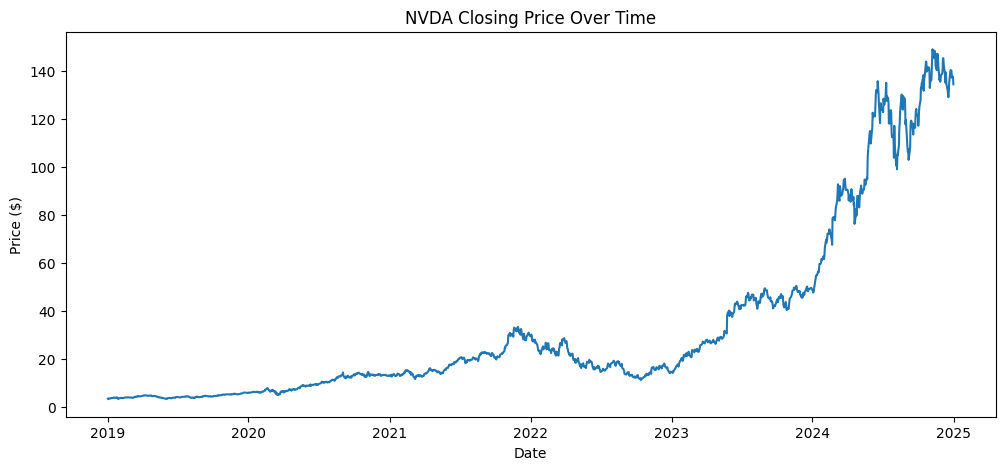

In [13]:
#price trend analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(cleaned_data.index, cleaned_data[f"{stock}_Close"])
plt.title(f"{stock} Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()


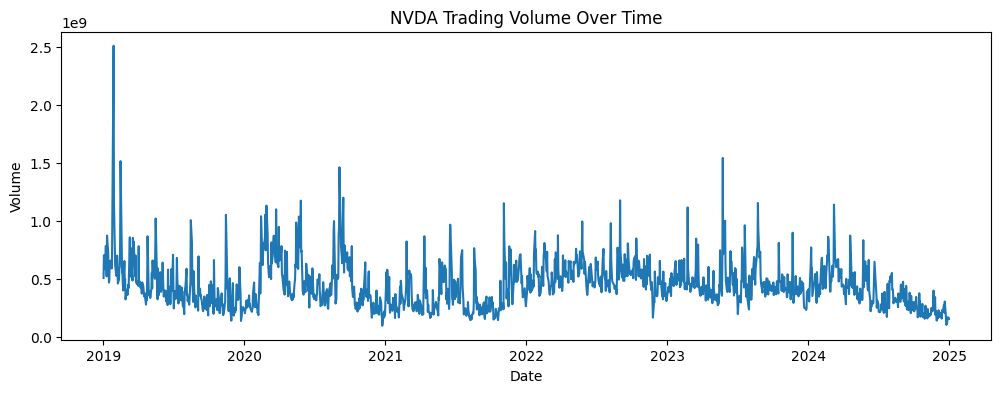

In [14]:
#volume analysis
plt.figure(figsize=(12, 4))
plt.plot(cleaned_data.index, cleaned_data[f"{stock}_Volume"])
plt.title(f"{stock} Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()


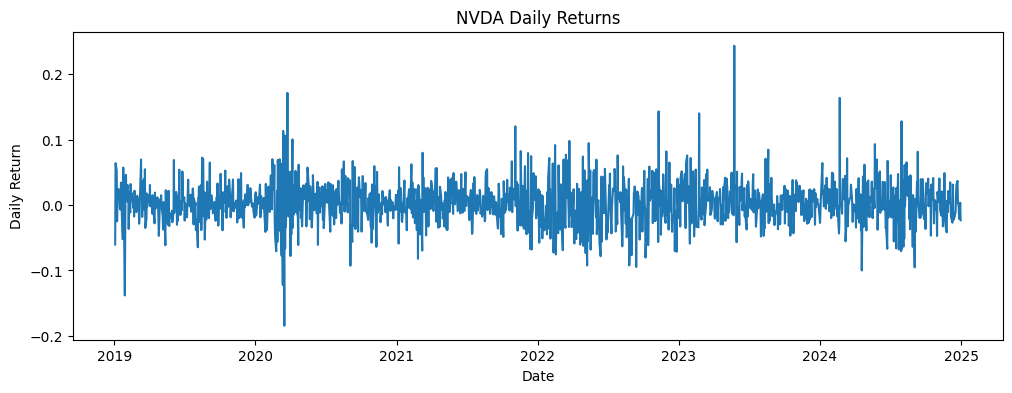

In [15]:
#Returns
returns = cleaned_data[f"{stock}_Close"].pct_change()

plt.figure(figsize=(12, 4))
plt.plot(returns)
plt.title(f"{stock} Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()


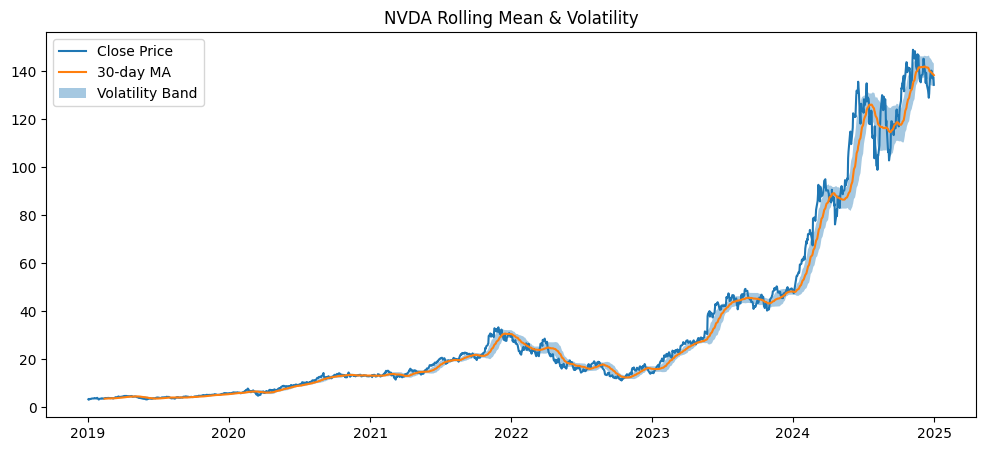

In [16]:
#Volatilty
rolling_mean = cleaned_data[f"{stock}_Close"].rolling(30).mean()
rolling_std = cleaned_data[f"{stock}_Close"].rolling(30).std()

plt.figure(figsize=(12, 5))
plt.plot(cleaned_data[f"{stock}_Close"], label="Close Price")
plt.plot(rolling_mean, label="30-day MA")
plt.fill_between(
    cleaned_data.index,
    rolling_mean - rolling_std,
    rolling_mean + rolling_std,
    alpha=0.4,
    label="Volatility Band"
)
plt.legend()
plt.title(f"{stock} Rolling Mean & Volatility")
plt.show()


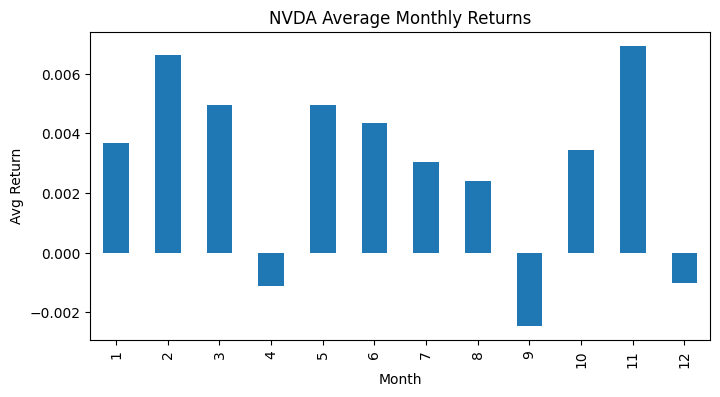

In [17]:
#seasonal analysis(monthly average return)
monthly_returns = returns.groupby(returns.index.month).mean()

plt.figure(figsize=(8, 4))
monthly_returns.plot(kind="bar")
plt.title(f"{stock} Average Monthly Returns")
plt.xlabel("Month")
plt.ylabel("Avg Return")
plt.show()


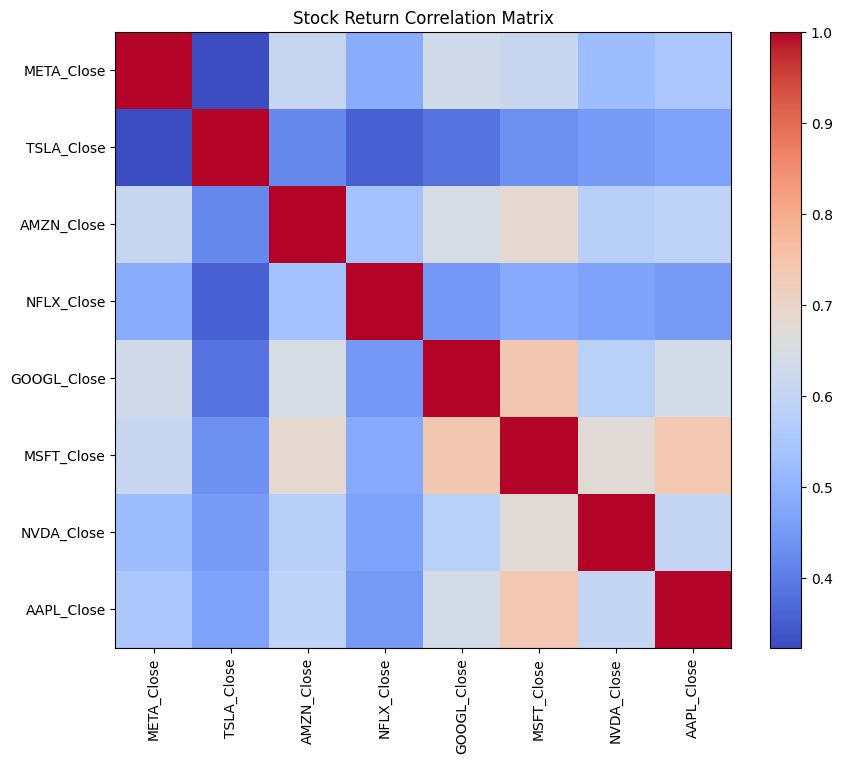

In [18]:
#corelation between stocks
close_cols = [c for c in cleaned_data.columns if c.endswith("_Close")]
close_prices = cleaned_data[close_cols]

corr = close_prices.pct_change().corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Stock Return Correlation Matrix")
plt.show()


**TASK 3**

In [19]:
stock = "NVDA"

price = cleaned_data[f"{stock}_Close"]
volume = cleaned_data[f"{stock}_Volume"]
#returns(percentage change)
features = pd.DataFrame(index=price.index)
features["return_1d"] = price.pct_change()
#lagged returns( to show autocorelation of market)
for lag in [1, 2, 3, 5]:
    features[f"return_lag_{lag}"] = features["return_1d"].shift(lag)
#Rolling mean(momentum)
features["ma_5"] = price.rolling(5).mean()
features["ma_10"] = price.rolling(10).mean()
features["ma_20"] = price.rolling(20).mean()

features["ma_ratio_5"] = price / features["ma_5"]
features["ma_ratio_10"] = price / features["ma_10"]
features["ma_ratio_20"] = price / features["ma_20"]
#Rolling vlatility(Risk)
features["volatility_5"] = features["return_1d"].rolling(5).std()
features["volatility_10"] = features["return_1d"].rolling(10).std()
features["volatility_20"] = features["return_1d"].rolling(20).std()
#Volume based(interest and liqidity)
features["volume_change"] = volume.pct_change()
features["volume_ma_5"] = volume.rolling(5).mean()
features["volume_ratio"] = volume / features["volume_ma_5"]
#target variables (preparing to train model in later cases if required)
features["target"] = features["return_1d"].shift(-1)
features = features.dropna() #remove NaNs created due to rolling and shifting
features.head()


,return_1d,return_lag_1,return_lag_2,return_lag_3,return_lag_5,ma_5,ma_10,ma_20,ma_ratio_5,ma_ratio_10,ma_ratio_20,volatility_5,volatility_10,volatility_20,volume_change,volume_ma_5,volume_ratio,target
Date,,,,,,,,,,,,,,,,,,
2019-01-31,0.046292,0.043997,-0.046446,-0.138245,0.057271,3.55450,3.688625,3.635812,1.011042,0.974279,0.988431,0.077925,0.060628,0.048943,-0.134851,1.327422e+09,0.634954,0.006817
2019-02-01,0.006817,0.046292,0.043997,-0.046446,0.014635,3.47740,3.671150,3.656737,1.040504,0.985590,0.989475,0.077233,0.060272,0.046545,-0.258413,1.221518e+09,0.511698,0.030747
2019-02-04,0.030747,0.006817,0.046292,0.043997,-0.138245,3.53325,3.651775,3.672975,1.055544,1.021284,1.015389,0.038413,0.060035,0.044973,-0.154318,8.249304e+08,0.640772,0.005162
2019-02-05,0.005162,0.030747,0.006817,0.046292,-0.046446,3.62500,3.654725,3.681162,1.034138,1.025727,1.018360,0.019739,0.057558,0.043572,0.026168,7.026288e+08,0.771992,0.020340
2019-02-06,0.020340,0.005162,0.030747,0.006817,0.043997,3.70305,3.664000,3.697625,1.032932,1.043941,1.034448,0.017200,0.057840,0.043210,0.295046,6.482760e+08,1.083588,-0.036471


In [20]:
# Ensure datetime index on both main frames
cleaned_data = cleaned_data.sort_index()
if not isinstance(cleaned_data.index, pd.DatetimeIndex):
    cleaned_data.index = pd.to_datetime(cleaned_data.index)

features = features.sort_index()
if not isinstance(features.index, pd.DatetimeIndex):
    features.index = pd.to_datetime(features.index)


**TASK 4**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.7 MB/s eta 0:00:00


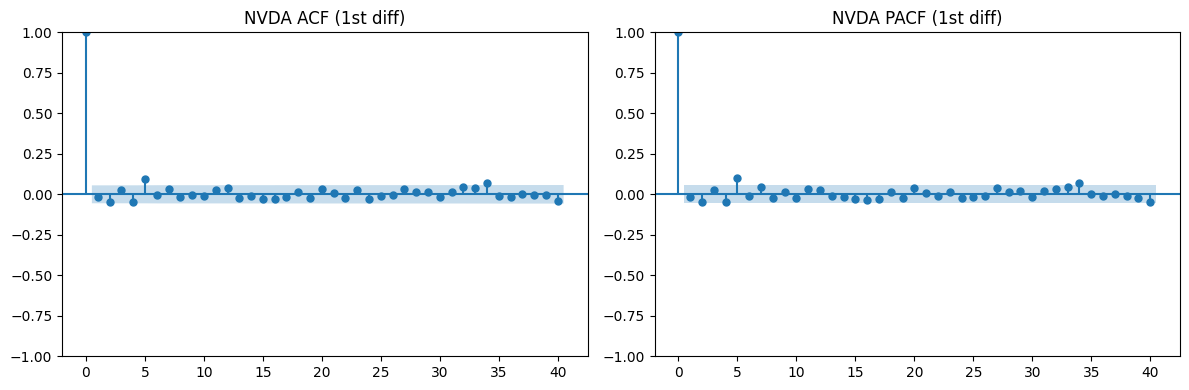

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2390.537, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2392.168, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2392.129, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2391.567, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2393.332, Time=0.91 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.737 seconds
Chosen ARIMA order (p,d,q): (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:             NVDA_Close   No. Observations:                 1252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1194.783
Date:                Tue, 16 Dec 2025   AIC                           2395.567
Time:                        06:25:48   BIC                           2410.962
Sample:                    01-02-2019   HQIC                          2401.354
                         - 10-19-2023 

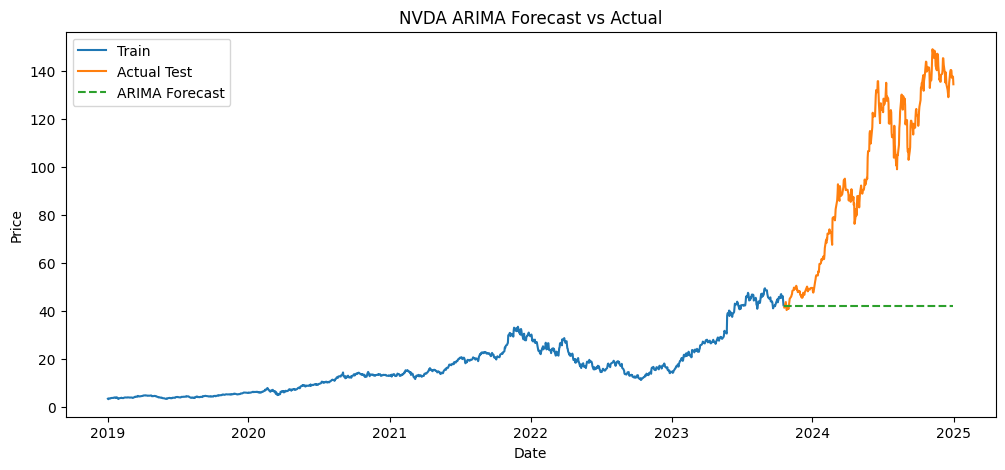

In [21]:
# ARIMA modeling for one stock (NVDA)
!pip install statsmodels pmdarima

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Use the same stock you set earlier
stock = "NVDA"
price = cleaned_data[f"{stock}_Close"].copy()

# Ensure sorted index and no NaNs
price = price.sort_index().asfreq("B")   # business-day frequency
price = price.ffill()

# Train-test split (e.g., last 20% for test)
split_idx = int(len(price) * 0.8)
train_price = price.iloc[:split_idx]
test_price = price.iloc[split_idx:]

# ACF and PACF plots to inspect p and q ranges
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_price.diff().dropna(), ax=axes[0], lags=40)
axes[0].set_title(f"{stock} ACF (1st diff)")
plot_pacf(train_price.diff().dropna(), ax=axes[1], lags=40, method="ywm")
axes[1].set_title(f"{stock} PACF (1st diff)")
plt.tight_layout()
plt.show()

# Automatic ARIMA order selection using pmdarima
auto_model = pm.auto_arima(
    train_price,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,          # let it decide differencing
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

print("Chosen ARIMA order (p,d,q):", auto_model.order)

# Fit final ARIMA on training data
arima_model = sm.tsa.ARIMA(train_price, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Forecast for test period length
n_test = len(test_price)
arima_forecast = arima_result.forecast(steps=n_test)
arima_forecast = pd.Series(arima_forecast, index=test_price.index)

# Evaluation
mae = mean_absolute_error(test_price, arima_forecast)
rmse = np.sqrt(mean_squared_error(test_price, arima_forecast))
print(f"ARIMA MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Plot actual vs forecast
plt.figure(figsize=(12, 5))
plt.plot(train_price.index, train_price, label="Train")
plt.plot(test_price.index, test_price, label="Actual Test")
plt.plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.title(f"{stock} ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


Since we are getting flat line, I will use ARIMA on returns insted of raw prices

                               SARIMAX Results                                
Dep. Variable:             NVDA_Close   No. Observations:                 1251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2524.697
Date:                Tue, 16 Dec 2025   AIC                          -5041.395
Time:                        06:25:53   BIC                          -5020.868
Sample:                    01-03-2019   HQIC                         -5033.678
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.335      0.020       0.000       0.004
ar.L1         -0.1524      0.262     -0.583      0.560      -0.665       0.360
ma.L1          0.0660      0.271      0.243      0.8

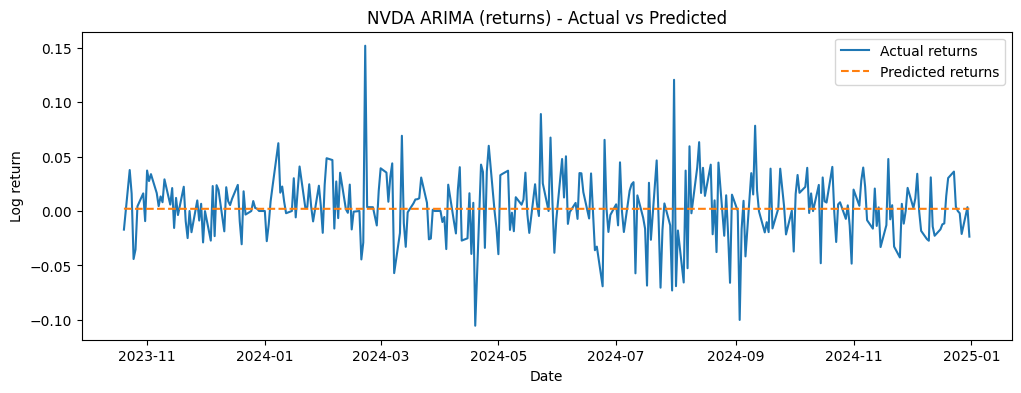

In [22]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Log-returns
stock = "NVDA"
price = cleaned_data[f"{stock}_Close"].asfreq("B").ffill()
log_price = np.log(price)
ret = log_price.diff().dropna()      # 1D series with Date index

# 2. Train–test split (keep datetime index)
split_idx = int(len(ret) * 0.8)
ret_train = ret.iloc[:split_idx]
ret_test  = ret.iloc[split_idx:]

# 3. Plain ARIMA(1,0,1) on returns (no exog)
model_ret = sm.tsa.ARIMA(ret_train, order=(1, 0, 1))
res_ret = model_ret.fit()
print(res_ret.summary())

# 4. Forecast returns; manual index = ret_test.index
ret_forecast = res_ret.forecast(steps=len(ret_test))
ret_forecast = pd.Series(ret_forecast, index=ret_test.index)

# 5. Evaluation in return space
ret_eval = pd.DataFrame({
    "actual_ret": ret_test,
    "pred_ret": ret_forecast
}).dropna()

print("Non-NaN return rows:", len(ret_eval))

actual_ret = ret_eval["actual_ret"]
pred_ret = ret_eval["pred_ret"]

mae_ret = mean_absolute_error(actual_ret, pred_ret)
rmse_ret = np.sqrt(mean_squared_error(actual_ret, pred_ret))
print(f"ARIMA on returns - MAE: {mae_ret:.6f}, RMSE: {rmse_ret:.6f}")

plt.figure(figsize=(12, 4))
plt.plot(actual_ret.index, actual_ret, label="Actual returns")
plt.plot(pred_ret.index,  pred_ret,  label="Predicted returns", linestyle="--")
plt.title(f"{stock} ARIMA (returns) - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Log return")
plt.legend()
plt.show()


observation:ARIMA’s assumptions (linear dynamics, Gaussian innovations, weak predictability) are too restrictive for highly volatile tech stocks, which is why the forecast path is much smoother than reality.

Using Cumulative returns:

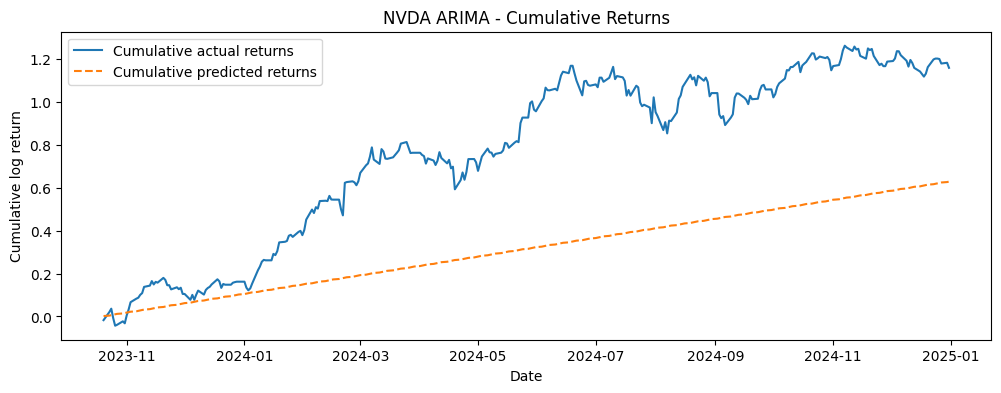

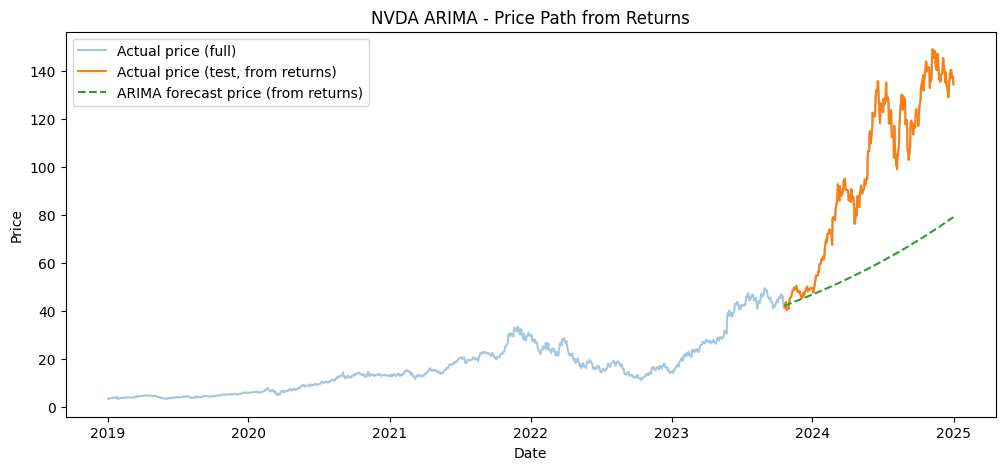

In [23]:
# 1) Cumulative actual and predicted returns (for analysis)
cum_actual_ret = ret_test.cumsum()
cum_pred_ret   = ret_forecast.cumsum()

plt.figure(figsize=(12, 4))
plt.plot(cum_actual_ret.index, cum_actual_ret, label="Cumulative actual returns")
plt.plot(cum_pred_ret.index,   cum_pred_ret,   label="Cumulative predicted returns", linestyle="--")
plt.title(f"{stock} ARIMA - Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative log return")
plt.legend()
plt.show()

# 2) Convert cumulative returns to prices (what you can show in the assignment)
# last training price as starting point
last_train_price = price.loc[ret_train.index[-1]]

price_actual_from_ret = last_train_price * np.exp(cum_actual_ret)
price_pred_from_ret   = last_train_price * np.exp(cum_pred_ret)

plt.figure(figsize=(12, 5))
plt.plot(price.index, price, label="Actual price (full)", alpha=0.4)
plt.plot(price_actual_from_ret.index, price_actual_from_ret, label="Actual price (test, from returns)")
plt.plot(price_pred_from_ret.index,   price_pred_from_ret,   label="ARIMA forecast price (from returns)", linestyle="--")
plt.title(f"{stock} ARIMA - Price Path from Returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_price_eval = pd.DataFrame({
    "actual_price": price_actual_from_ret,
    "pred_price":   price_pred_from_ret
}).dropna()

mae_price = mean_absolute_error(df_price_eval["actual_price"], df_price_eval["pred_price"])
rmse_price = np.sqrt(mean_squared_error(df_price_eval["actual_price"], df_price_eval["pred_price"]))
print(f"ARIMA (returns → price) MAE: {mae_price:.4f}, RMSE: {rmse_price:.4f}")


ARIMA (returns → price) MAE: 39.1267, RMSE: 45.7719


Gradient Boosting

Baseline GBR MAE: 0.028883, RMSE: 0.037290


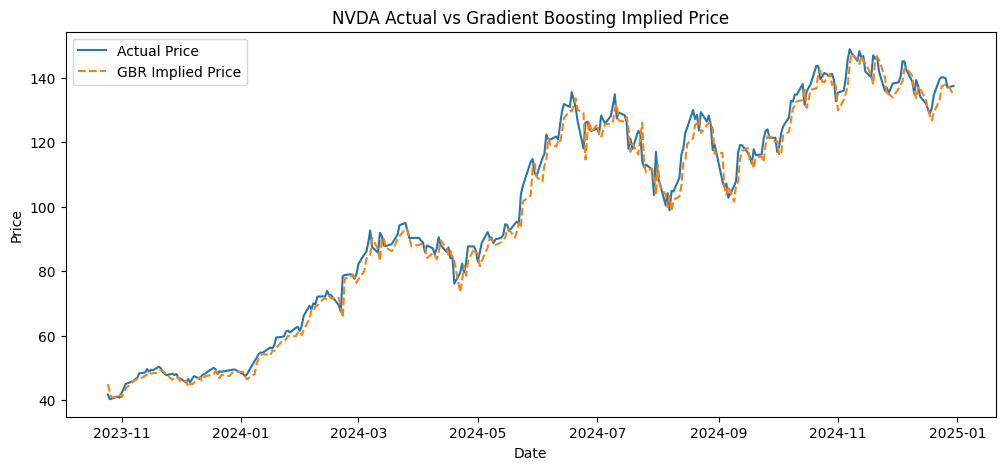

In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use your existing 'features' DataFrame with engineered variables and 'target'
# Make sure there are no NaNs
dataset = features.dropna().copy()

X = dataset.drop(columns=["target"])
y = dataset["target"]

# Time-series split for train/test (e.g., last 20% as test)
split_idx = int(len(dataset) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Basic Gradient Boosting model
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Baseline GBR MAE: {mae_gbr:.6f}, RMSE: {rmse_gbr:.6f}")

# Map predicted returns to price level for comparison (optional)
# Align with actual price series
price_aligned = price.loc[dataset.index]
test_price_level = price_aligned.iloc[split_idx:]          # actual price
predicted_return = pd.Series(y_pred, index=test_price_level.index)

# Simple one-step-ahead “price prediction” from returns
predicted_price = test_price_level.shift(1) * (1 + predicted_return)
# First value may be NaN due to shift; drop it for plotting
valid_idx = predicted_price.dropna().index

plt.figure(figsize=(12, 5))
plt.plot(test_price_level.loc[valid_idx], label="Actual Price")
plt.plot(predicted_price.loc[valid_idx], label="GBR Implied Price", linestyle="--")
plt.title(f"{stock} Actual vs Gradient Boosting Implied Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

gbr_base = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gbr_base,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (neg MSE):", grid_search.best_score_)

best_gbr = grid_search.best_estimator_
y_pred_best = best_gbr.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Tuned GBR MAE: {mae_best:.6f}, RMSE: {rmse_best:.6f}")


Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Best CV score (neg MSE): -0.0011873963585373177
Tuned GBR MAE: 0.023487, RMSE: 0.031471


Checking if the Gradient Boosting Model is overfitted or well trained

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

dataset = features.dropna().copy()
X = dataset.drop(columns=["target"])
y = dataset["target"]

tscv = TimeSeriesSplit(n_splits=5)

fold_mae_train = []
fold_rmse_train = []
fold_mae_val = []
fold_rmse_val = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = GradientBoostingRegressor(
        random_state=42,
        n_estimators=grid_search.best_params_["n_estimators"],
        learning_rate=grid_search.best_params_["learning_rate"],
        max_depth=grid_search.best_params_["max_depth"],
        subsample=grid_search.best_params_["subsample"],
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    mae_tr = mean_absolute_error(y_train, y_train_pred)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_v = mean_absolute_error(y_val, y_val_pred)
    rmse_v = np.sqrt(mean_squared_error(y_val, y_val_pred))

    fold_mae_train.append(mae_tr)
    fold_rmse_train.append(rmse_tr)
    fold_mae_val.append(mae_v)
    fold_rmse_val.append(rmse_v)

    print(f"Fold {fold}:")
    print(f"  Train  MAE={mae_tr:.4f}, RMSE={rmse_tr:.4f}")
    print(f"  Val    MAE={mae_v:.4f}, RMSE={rmse_v:.4f}")
    print("-" * 40)

print("Average over folds:")
print(f"  Train MAE={np.mean(fold_mae_train):.4f}, RMSE={np.mean(fold_rmse_train):.4f}")
print(f"  Val   MAE={np.mean(fold_mae_val):.4f}, RMSE={np.mean(fold_rmse_val):.4f}")


Fold 1:
  Train  MAE=0.0158, RMSE=0.0207
  Val    MAE=0.0265, RMSE=0.0370
----------------------------------------
Fold 2:
  Train  MAE=0.0205, RMSE=0.0276
  Val    MAE=0.0215, RMSE=0.0285
----------------------------------------
Fold 3:
  Train  MAE=0.0208, RMSE=0.0279
  Val    MAE=0.0326, RMSE=0.0407
----------------------------------------
Fold 4:
  Train  MAE=0.0237, RMSE=0.0314
  Val    MAE=0.0209, RMSE=0.0305
----------------------------------------
Fold 5:
  Train  MAE=0.0231, RMSE=0.0312
  Val    MAE=0.0250, RMSE=0.0334
----------------------------------------
Average over folds:
  Train MAE=0.0208, RMSE=0.0278
  Val   MAE=0.0253, RMSE=0.0340


In [ ]:
# final chronological split (same as before)
split_idx = int(len(dataset) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

best_gbr = GradientBoostingRegressor(
    random_state=42,
    **grid_search.best_params_
)
best_gbr.fit(X_train, y_train)

y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train MAE={mae_train:.4f}, RMSE={rmse_train:.4f}")
print(f"Test  MAE={mae_test:.44f}, RMSE={rmse_test:.4f}")


Train MAE=0.0234, RMSE=0.0316
Test  MAE=0.02348685032361786870214181988103518960997462, RMSE=0.0315


Since the Train and Test scores are close to each other model is well trained and not overfitted

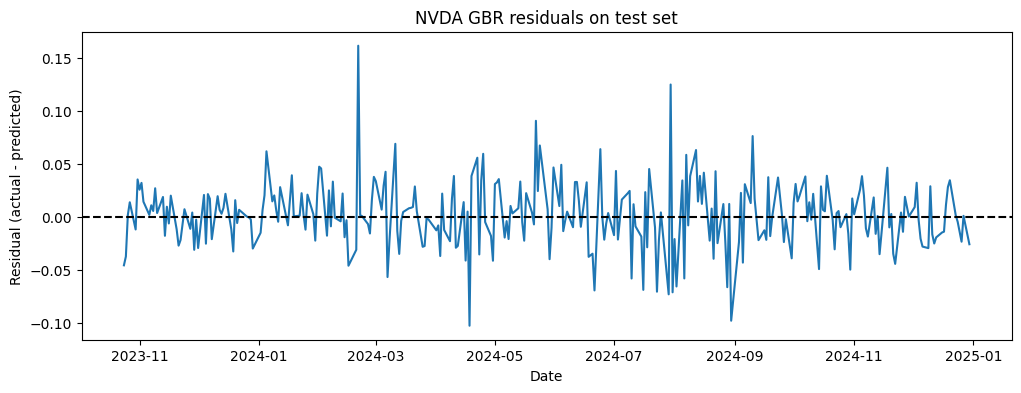

In [ ]:
import matplotlib.pyplot as plt

residuals = pd.Series(y_test - y_test_pred, index=y_test.index)

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.axhline(0, color="black", linestyle="--")
plt.title(f"{stock} GBR residuals on test set")
plt.xlabel("Date")
plt.ylabel("Residual (actual - predicted)")
plt.show()


**Task 5**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- ARIMA: returns (ret_test, ret_forecast already computed) ---
ret_eval = pd.DataFrame({
    "actual_ret": ret_test,
    "pred_ret":  ret_forecast
}).dropna()

arima_ret_mae  = mean_absolute_error(ret_eval["actual_ret"], ret_eval["pred_ret"])
arima_ret_rmse = np.sqrt(mean_squared_error(ret_eval["actual_ret"], ret_eval["pred_ret"]))
arima_ret_mape = np.mean(
    np.abs((ret_eval["actual_ret"] - ret_eval["pred_ret"]) /
           ret_eval["actual_ret"])
) * 100  # may be unstable if returns ~0

print("ARIMA (returns)  MAE : {:.6f}".format(arima_ret_mae))
print("ARIMA (returns)  RMSE: {:.6f}".format(arima_ret_rmse))
print("ARIMA (returns)  MAPE: {:.2f}%".format(arima_ret_mape))

# --- ARIMA: prices from cumulative returns (already have price_actual_from_ret, price_pred_from_ret) ---
df_arima_price = pd.DataFrame({
    "actual_price": price_actual_from_ret,
    "pred_price":   price_pred_from_ret
}).dropna()

arima_price_mae  = mean_absolute_error(df_arima_price["actual_price"], df_arima_price["pred_price"])
arima_price_rmse = np.sqrt(mean_squared_error(df_arima_price["actual_price"], df_arima_price["pred_price"]))
arima_price_mape = np.mean(
    np.abs((df_arima_price["actual_price"] - df_arima_price["pred_price"]) /
           df_arima_price["actual_price"])
) * 100

print("\nARIMA (price)    MAE : {:.4f}".format(arima_price_mae))
print("ARIMA (price)    RMSE: {:.4f}".format(arima_price_rmse))
print("ARIMA (price)    MAPE: {:.2f}%".format(arima_price_mape))

# --- GBR: returns (y_test, y_test_pred from best_gbr) ---
gbr_ret_eval = pd.DataFrame({
    "actual_ret": y_test,
    "pred_ret":   y_test_pred
}).dropna()

gbr_ret_mae  = mean_absolute_error(gbr_ret_eval["actual_ret"], gbr_ret_eval["pred_ret"])
gbr_ret_rmse = np.sqrt(mean_squared_error(gbr_ret_eval["actual_ret"], gbr_ret_eval["pred_ret"]))
gbr_ret_mape = np.mean(
    np.abs((gbr_ret_eval["actual_ret"] - gbr_ret_eval["pred_ret"]) /
           gbr_ret_eval["actual_ret"])
) * 100  # will likely blow up because many returns are ~0

print("\nGBR (returns)    MAE : {:.6f}".format(gbr_ret_mae))
print("GBR (returns)    RMSE: {:.6f}".format(gbr_ret_rmse))
print("GBR (returns)    MAPE: {:.2f}%".format(gbr_ret_mape))

# --- GBR: prices from predicted returns (implied price) ---
# price_aligned and split_idx are already defined in your GBR section
price_aligned = price.loc[dataset.index]
actual_price_test = price_aligned.iloc[split_idx:]
pred_ret_series   = pd.Series(y_test_pred, index=actual_price_test.index)

gbr_pred_price = actual_price_test.shift(1) * (1 + pred_ret_series)

df_gbr_price = pd.DataFrame({
    "actual_price": actual_price_test,
    "pred_price":   gbr_pred_price
}).dropna()

gbr_price_mae  = mean_absolute_error(df_gbr_price["actual_price"], df_gbr_price["pred_price"])
gbr_price_rmse = np.sqrt(mean_squared_error(df_gbr_price["actual_price"], df_gbr_price["pred_price"]))
gbr_price_mape = np.mean(
    np.abs((df_gbr_price["actual_price"] - df_gbr_price["pred_price"]) /
           df_gbr_price["actual_price"])
) * 100

print("\nGBR (price)      MAE : {:.4f}".format(gbr_price_mae))
print("GBR (price)      RMSE: {:.4f}".format(gbr_price_rmse))
print("GBR (price)      MAPE: {:.2f}%".format(gbr_price_mape))


ARIMA (returns)  MAE : 0.022442
ARIMA (returns)  RMSE: 0.030444
ARIMA (returns)  MAPE: inf%

ARIMA (price)    MAE : 39.1267
ARIMA (price)    RMSE: 45.7719
ARIMA (price)    MAPE: 34.96%

GBR (returns)    MAE : 0.023487
GBR (returns)    RMSE: 0.031471
GBR (returns)    MAPE: inf%

GBR (price)      MAE : 2.3386
GBR (price)      RMSE: 3.2638
GBR (price)      MAPE: 2.33%


MAPE explodes because some returns are very close to 0,MAPE is unstable for return series.

Comparison between both the models: ARIMA (returns → prices) produces much larger errors than Gradient Boosting on the same test period, confirming that a simple linear time‑series model is not sufficient for capturing NVDA’s complex dynamics, while Gradient Boosting with engineered features performs significantly better.

In [ ]:
# NVIDIA model performance summary (returns + prices)

metrics_nvda = pd.DataFrame([
    ["ARIMA", "Returns", arima_ret_mae,  arima_ret_rmse,  arima_ret_mape],
    ["ARIMA", "Prices",  arima_price_mae, arima_price_rmse, arima_price_mape],
    ["GBR",   "Returns", gbr_ret_mae,    gbr_ret_rmse,    gbr_ret_mape],
    ["GBR",   "Prices",  gbr_price_mae,  gbr_price_rmse,  gbr_price_mape],
], columns=["Model", "Space", "MAE", "RMSE", "MAPE"])

metrics_nvda


,Model,Space,MAE,RMSE,MAPE
0,ARIMA,Returns,0.022442,0.030444,inf
1,ARIMA,Prices,39.126706,45.771861,34.961518
2,GBR,Returns,0.023487,0.031471,inf
3,GBR,Prices,2.338603,3.263783,2.327981


In [ ]:
# Save as CSV for Tableau / Power BI / GCS
metrics_nvda.to_csv("nvda_model_metrics.csv", index=False)


Trying One step ahead returns for ARIMA:

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


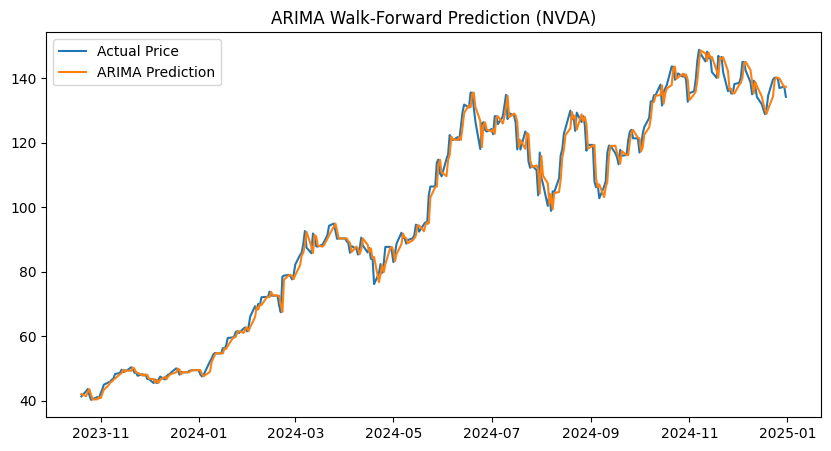

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

log_price = np.log(price)

split = int(len(log_price) * 0.8)
train = log_price.iloc[:split]
test  = log_price.iloc[split:]

history = train.copy()
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    fit = model.fit()

    yhat = fit.forecast(steps=1)
    predictions.append(yhat.iloc[0])

    history = pd.concat([history, test.iloc[t:t+1]])

# Convert back to prices
predicted_prices = np.exp(predictions)
actual_prices = np.exp(test)

# Plot
plt.figure(figsize=(10,5))
plt.plot(actual_prices.index, actual_prices, label="Actual Price")
plt.plot(actual_prices.index, predicted_prices, label="ARIMA Prediction")
plt.title("ARIMA Walk-Forward Prediction (NVDA)")
plt.legend()
plt.show()
